## **Vehicle Detection Project**


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

### 1. Compute Color Histogram Features and Histogram of Orientated Gradiens (HOG)

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

##### 1> Compute Color Histogram Features 

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately 
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


##### 2> Compute HOG

In [3]:
from skimage.feature import hog

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

##### 3> Feature Extraction

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
   
    '''
       Extraction of features: 1. Spatial binning of color;
                               2. Histograms of color
                               3. HOG
    '''
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = cv2.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)    
            
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
    # Return list of feature vectors
    return features

### 2. Train a linear SVM classifier

##### 1> Read Image Names

In [6]:
# Divide up into cars and notcars
cars = []
notcars = []

# Read Car Image Names
folders_cars = glob.glob('./data/vehicles/*')
for folder in folders_cars:
    for f in glob.glob(folder+'/*.png'):
        cars.append(f)


# Read Non-Car Image Names
folders_non_cars = glob.glob('./data/non-vehicles/*')
for folder in folders_non_cars:
    sub_notcars = []
    for f in glob.glob(folder+'/*.png'):
        notcars.append(f)
        
    
    

##### 2> Check Dataset Information

Dataset Information:  number of car images 8792 
                      number of not_car images 8968
                      Image Size:  (64, 64, 3) 
                      data type: uint8
                      Intensity range of chosen image: [14, 253]


Text(0.5,1,'Example Not-car Image')

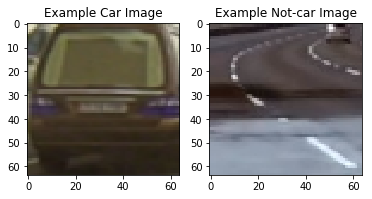

In [7]:
## check balance between "cars" and "notcars" data

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    
    # Dataset characteristic list
    data_dict = {}
    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    img = cv2.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] =img.dtype
    
    # Define a key "intensity range" of the chosen image.
    data_dict["intensity_range"] = [np.min(img), np.max(img)]
    
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Dataset Information: ', 
      'number of car images', data_info["n_cars"], '\n', 
      '                     number of not_car images', data_info["n_notcars"])
print('                      Image Size: ',data_info["image_shape"], '\n'
      '                      data type:', 
                 data_info["data_type"])
print('                      Intensity range of chosen image:', data_info["intensity_range"])


#  choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

##### 2> Extract Features from the images and Split Dataset

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Feature Extraction Parameters

# HOG
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 4
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Color
spatial = 16
histbin = 32


# Car Features
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_size = (spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Non-Car Features
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_size = (spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler on training set
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')

print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 4 cells per block
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 11664


##### 3> Fit SVM

In [11]:
from sklearn.svm import LinearSVC

#Use a linear SVC 
svc = LinearSVC()

# Train Data
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check selected data in test_data_set
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9899
My SVC predicts:  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]





##### 4> Save Model

In [13]:
import pickle

# save the model to disk
filename = 'svc.p'
pickle.dump(svc, open(filename, 'wb'))

# save the scaler
filename = 'X_scaler.p'
pickle.dump(X_scaler, open(filename, 'wb'))
